# ML Zoomcamp Homework 2
This HW goal is to work with the California Housing Prices from Kaggle to make predictions using Linear Regression.

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## EDA

### Loading the data

In [2]:
df = pd.read_csv('housing.csv')

In [3]:
len(df)

20640

In [4]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
df.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

### Checking median house feature

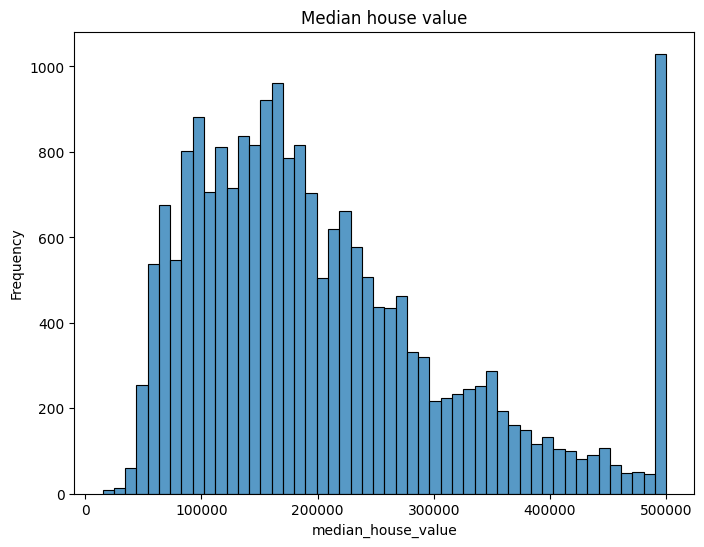

In [6]:
# Histogram
plt.figure(figsize=(8, 6))
sns.histplot(df['median_house_value'], bins=50, kde=False)
plt.title('Median house value')
plt.xlabel('median_house_value')
plt.ylabel('Frequency')

plt.show();

From the histogram we can see we are dealing with right skewed data. It does have a tail, not as long as we saw in the car price dataset but it has, it is not a normal distribution.

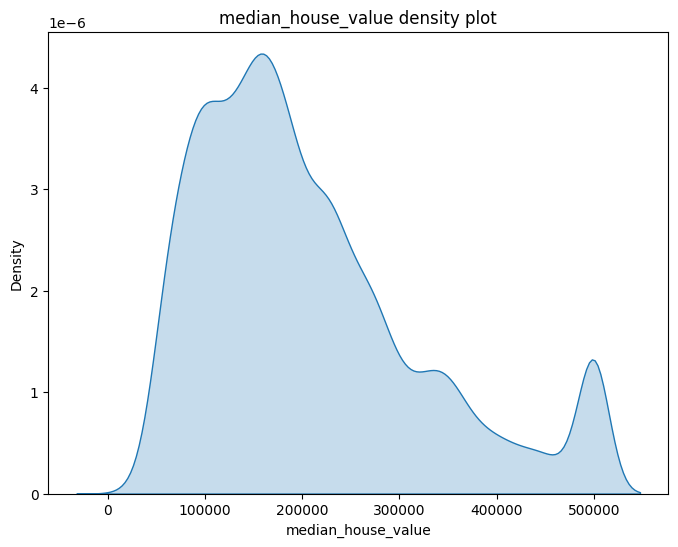

In [7]:
# KDE-Kernel Density Estimate
plt.figure(figsize=(8,6))
sns.kdeplot(df['median_house_value'], fill=True)
plt.title('median_house_value density plot')
plt.xlabel('median_house_value')
plt.ylabel('Density')
plt.show()

Here we can see that we have a peak around 200K (most common range is arounf here) and again a long tail to the right (this is very usual when we're talking about financial data).  
The long tail tells us that we have houses with much higher values (these are less frequent but I think we have a good amount around $ 500K.

In [8]:
df_filtered = df.loc[(df['ocean_proximity'] == '<1H OCEAN') | (df['ocean_proximity'] ==  'INLAND')]

In [9]:
columns_to_keep = [
    'latitude', 
    'longitude', 
    'housing_median_age', 
    'total_rooms', 
    'total_bedrooms', 
    'population', 
    'households', 
    'median_income', 
    'median_house_value'
]

df_subset = df_filtered[columns_to_keep]

In [10]:
df_subset.head()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
701,37.64,-121.97,32.0,1283.0,194.0,485.0,171.0,6.0574,431000.0
830,37.61,-121.99,9.0,3666.0,711.0,2341.0,703.0,4.6458,217000.0
859,37.57,-121.97,21.0,4342.0,783.0,2172.0,789.0,4.6146,247600.0
860,37.58,-121.96,15.0,3575.0,597.0,1777.0,559.0,5.7192,283500.0
861,37.58,-121.98,20.0,4126.0,1031.0,2079.0,975.0,3.6832,216900.0


## Question 1

In [11]:
df_subset.isnull().sum()

latitude                0
longitude               0
housing_median_age      0
total_rooms             0
total_bedrooms        157
population              0
households              0
median_income           0
median_house_value      0
dtype: int64

**Answer:** The feature with missing Values is total_bedrooms with 157 missing values

## Question 2

In [12]:
population_median = df_subset['population'].median()
population_median

1195.0

**Answer:** 1195

## Prepare and Split the dataset

- Shuffle the dataset (the filtered one you created above), use seed 42.
- Split your data in train/val/test sets, with 60%/20%/20% distribution.

In [13]:
# computing the sample size
n = len(df_subset)
n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

In [14]:
# create the index array
idx = np.arange(n)

# set the random seed
np.random.seed(42)

# shuffle
np.random.shuffle(idx)

In [15]:
df_train = df_subset.iloc[idx[:n_train]]
df_val = df_subset.iloc[idx[n_train:n_train+n_val]]
df_test = df_subset.iloc[idx[n_train+n_val:]]

In [16]:
df_train = df_train.copy()
df_val = df_val.copy()
df_test = df_test.copy()


df_train['median_house_value'] = np.log1p(df_train['median_house_value'])
df_val['median_house_value'] = np.log1p(df_val['median_house_value'])
df_test['median_house_value'] = np.log1p(df_test['median_house_value'])

## Question 3
- We need to deal with missing values for the column from Q1.
- We have two options: fill it with 0 or with the mean of this - variable.
- Try both options. For each, train a linear regression model without - regularization using the code from the lessons.
- For computing the mean, use the training only!
- Use the validation dataset to evaluate the models and compare the - RMSE of each option.
- Round the RMSE scores to 2 decimal digits using round(score, 2)
- Which option gives better RMSE?

In [19]:
# LR train code
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [20]:
# RMSE code
def rmse(y, y_pred):
    error = (y - y_pred) ** 2
    mse = error.mean()
    return np.sqrt(mse)

In [37]:
# Data prep to fill with zero
def prepare_X_zeros(df):
    df_num = df.drop(columns=['median_house_value']).copy()  # Exclude the target variable
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [38]:
X_train = prepare_X_zeros(df_train)
y_train = df_train['median_house_value'].values

w0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X_zeros(df_val)
y_val = df_val['median_house_value'].values
y_pred = w0 + X_val.dot(w)
score_zero = rmse(y_val, y_pred)

score_zero

0.34084790341805027

In [41]:
mean_value = df_train['total_bedrooms'].mean()

def prepare_X_mean(df):
    df_num = df.drop(columns=['median_house_value']).copy()  # Exclude the target variable
    df_num = df_num.copy()
    df_num['total_bedrooms'] = df_num['total_bedrooms'].fillna(mean_value)
    X = df_num.values
    return X

X_train_mean = prepare_X_mean(df_train)
w0_mean, w_mean = train_linear_regression(X_train_mean, y_train)

X_val_mean = prepare_X_mean(df_val)
y_pred_mean = w0_mean + X_val_mean.dot(w_mean)
score_mean = rmse(y_val, y_pred_mean)

score_mean

0.34056998014435774

**Answer:** From the results above we can see that both approaches are equally good.

## Question 4

In [42]:
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    
    # adding a small no to the diagonal
    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [47]:
for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    X_train = prepare_X_zeros(df_train)
    y_train = df_train['median_house_value'].values

    w0, w = train_linear_regression_reg(X_train, y_train, r=r)
    
    X_val = prepare_X_zeros(df_val)
    y_pred = w0 + X_val.dot(w)
    score = rmse(y_val, y_pred)
    score_rounded = rmse(y_val, y_pred).round(2)
    
    print(r, w0, score, score_rounded)

0 -9.763249477781574 0.34084790341805027 0.34
1e-06 -9.763228831278607 0.3408479061781417 0.34
0.0001 -9.761185235807432 0.3408481800532395 0.34
0.001 -9.74264624932001 0.340850692188389 0.34
0.01 -9.561056193283042 0.34087793005172373 0.34
0.1 -8.058889769581874 0.34128620419969663 0.34
1 -3.1331542785255584 0.3448958327652831 0.34
5 -0.8410867974326546 0.34773980704852353 0.35
10 -0.43811723161578703 0.34831498335175287 0.35


**Answer:** As the results are very similar when we round we have 0.34 for the marjority of the results. So, let's choose the minor r value that gives us the minor RMSe which is **r=0**

## Question 5

In [49]:
# Initialize the list to store the RMSE scores for different seeds
rmse_scores = []

# loop over the different seed values
for seed in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    # Create the index array and shuffle it using the current seed
    idx = np.arange(n)
    np.random.seed(seed)
    np.random.shuffle(idx)
    
    # Splitting the dataframe into train, validation, and test sets using the shuffled indices
    df_train = df_subset.iloc[idx[:n_train]].copy()
    df_val = df_subset.iloc[idx[n_train:n_train+n_val]].copy()
    df_test = df_subset.iloc[idx[n_train+n_val:]].copy()
    
    # Apply logarithmic transformation to 'median_house_value'
    df_train['median_house_value'] = np.log1p(df_train['median_house_value'])
    df_val['median_house_value'] = np.log1p(df_val['median_house_value'])
    df_test['median_house_value'] = np.log1p(df_test['median_house_value'])
    
    # Prepare the training data with zeros filling, train the linear regression model, make predictions and calculate RMSE
    X_train = prepare_X_zeros_fixed(df_train)
    y_train = df_train['median_house_value'].values
    
    w0, w = train_linear_regression(X_train, y_train)
    
    X_val = prepare_X_zeros_fixed(df_val)
    y_val = df_val['median_house_value'].values
    
    y_pred = w0 + X_val.dot(w)
    score = rmse(y_val, y_pred)
    
    # Append the current RMSE score to the list of corrected scores
    rmse_scores.append(score)
    
# Calculate the standard deviation of the corrected RMSE scores and round it to 3 decimal digits
std_rmse_corrected = round(np.std(rmse_scores), 3)
std_rmse_corrected

0.005

**Answer:** 0.005

In [50]:
# Set the seed value
seed = 9

# Create the index array and shuffle it using the seed
idx = np.arange(n)
np.random.seed(seed)
np.random.shuffle(idx)

# Splitting the dataframe into combined train and validation, and test sets using the shuffled indices
df_train_val = df_subset.iloc[idx[:n_train+n_val]].copy()
df_test = df_subset.iloc[idx[n_train+n_val:]].copy()

# Apply logarithmic transformation to 'median_house_value'
df_train_val['median_house_value'] = np.log1p(df_train_val['median_house_value'])
df_test['median_house_value'] = np.log1p(df_test['median_house_value'])

# Prepare the combined training and validation data with zeros filling
X_train_val = prepare_X_zeros_fixed(df_train_val)
y_train_val = df_train_val['median_house_value'].values

# Train the regularized linear regression model with r=0.001 on the combined training and validation data
w0_tv, w_tv = train_linear_regression_reg(X_train_val, y_train_val, r=0.001)

# Prepare the test data with zeros filling
X_test = prepare_X_zeros_fixed(df_test)
y_test = df_test['median_house_value'].values

# Make predictions on the test data and calculate RMSE
y_pred_test = w0_tv + X_test.dot(w_tv)
score_test = rmse(y_test, y_pred_test)
score_test_rounded = round(score_test, 2)
score_test_rounded


0.33

**Answer:** 0.33